# Tumor detection using Active Contour :

- Active contour is a method for image segmentation that uses edge detection. A contour is defined in the begining and then it is evolved in order to divide the image into segmments. Here is an implementation of the Chan-Vese method where we start with a checker board initialization (sinus function) and iterate over it in order to find the best segmentation. In this example we cannot apply the method to the whole image otherwise we will only get a segmentation of the brain and the background, so to remediate to this problem we only consider a small snippet that contains the tumor and do the segmentation on it. We thus obtain a shrinkage of 8.85% of the tumor.

- Les méthodes de Contour actif sont des méthodes de segmentation d’image qui se base sur la détection de contours. Un contour est défini au début, puis est évolué pour diviser l'image en segments. Dans ce TP j'utilise mon implémentation de la méthode Chan-Vese dans laquelle nous commençons par une initialisation du damier (fonction sinus) et itérons dessus pour trouver la meilleure segmentation. Dans cet exemple, nous ne pouvons pas appliquer la méthode à l’ensemble de l’image. Par conséquent, pour remédier à ce problème, considérons unse petite imagette contenant la tumeur et effectuons la segmentation correspondante. Nous obtenons ainsi un rétrécissement de 8,85% de la tumeur.

- https://github.com/A-EL-YAAGOUBI/Differential-equations/blob/master/Chan-Vese%20segmentation%20method/Chan_Vese_Segmentation_Presentation.pdf


In [1]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from skimage import measure
from collections import Counter
import math

## Loading the MRI images

In [2]:
IRMcoupe17_t1 = Image.open('./images/IRMcoupe17-t1.jpg')
IRMcoupe17_t2 = Image.open('./images/IRMcoupe17-t2.jpg')

IRMcoupe17_t1 = np.array(IRMcoupe17_t1)
IRMcoupe17_t2 = np.array(IRMcoupe17_t2)

## Visualizing the images

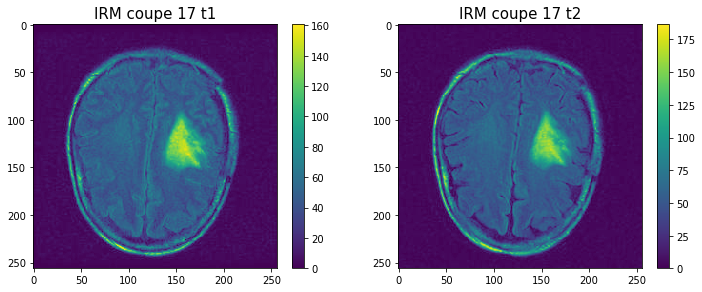

In [3]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.imshow(IRMcoupe17_t1)
plt.title('IRM coupe 17 t1', fontsize=15)
plt.colorbar(shrink=0.9)

plt.subplot(1, 2, 2)
plt.imshow(IRMcoupe17_t2)
plt.title('IRM coupe 17 t2', fontsize=15)
plt.colorbar(shrink=0.9)

plt.show()

## Defining Auxilary functions that implement the Chan-Vese method
- I read the following paper in order to implement the Chan-Vese method :
- https://www.ipol.im/pub/art/2012/g-cv/article.pdf

In [4]:
def square(x):
    return x*x

def nabla_plus(x_n, i, j, axis=0):
    if axis == 0:
        if j == x_n.shape[1]-1:
            return 0
        else:
            return (x_n[i,j+1] - x_n[i,j])/2

    if axis == 1:
        if i == x_n.shape[0]-1:
            return 0
        else:
            return (x_n[i+1,j] - x_n[i,j])/2
    

def nabla_minus(x_n, i, j, axis=0):
    if axis == 0:
        if j == 0:
            return 0
        else:
            return (x_n[i,j-1] - x_n[i,j])/2

    if axis == 1:
        if i == 0:
            return 0
        else:
            return (x_n[i-1,j] - x_n[i,j])/2

def get_phi(phi, i, j): 
    return phi[min(max(i,0),phi.shape[0]-1),min(max(j,0),phi.shape[1]-1)]

def nabla_zero(x_n, i, j,axis=0):
    return (nabla_plus(x_n, i, j, axis) + nabla_minus(x_n, i, j, axis)) / 2

def A(phi, i, j, mu=0.2, eta=1e-8):
    return mu / np.sqrt(square(eta) + square(nabla_plus(phi, i, j, axis=1)) + square(nabla_zero(phi, i, j, axis=0)))

def B(phi, i, j, mu=0.2, eta=1e-8):
    return mu / np.sqrt(square(eta) + square(nabla_plus(phi, i, j, axis=0)) + square(nabla_zero(phi, i, j, axis=1)))

def delta_regularized(x,epsilon=1):
    return epsilon / (math.pi*(square(epsilon) + square(x)))   


def init_phi(x): # x is an image
    # Checkboard function as an initialization of phi
    res = np.zeros(x.shape)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            res[i,j] = math.sin(math.pi/5 * i)*math.sin(math.pi/5 * j)
    return res

def u(img,phi): # x is an image
    c1 = np.mean(img[phi > 0])
    c2 = np.mean(img[phi <= 0])

    res = np.zeros(img.shape)
    res[phi > 0] = c1
    res[phi <= 0] = c2
    return c1,c2, res 
    

def update_phi(f, c1, c2, phi, dt=0.5, nu = 0, lambda1 = 1 ,lambda2 = 1): #Tout le travail est là
    for i in range(phi.shape[0]):
        for j in range(phi.shape[1]):
            numerator = get_phi(phi,i,j) + dt * delta_regularized(get_phi(phi,i,j)) * (A(phi,i,j) * get_phi(phi,i-1,j) + B(phi,i,j) * get_phi(phi,i,j+1) + B(phi,i,j-1) * get_phi(phi,i,j-1) - nu - lambda1 * square(f[i,j] - c1) + lambda2 * square(f[i,j] - c2))
            denominator = 1 + dt*delta_regularized(get_phi(phi,i,j))*(A(phi,i,j) + A(phi,i-1,j) + B(phi,i,j) + B(phi,i,j-1))
            phi[i,j] = numerator / denominator
      
    return phi

def chan_vese(f, ITER_MAX=20, tol=1e-1):
    print('Chan-Vese method :')
    images = []
    phi      = init_phi(f)
    last_phi = phi.copy() + 1

    phis = [phi]
    i = 0
    while i < ITER_MAX and np.linalg.norm(last_phi - phi) > tol:
        i += 1
        if i % 5 == 0:
            print('Iteration {}'.format(i))
        c1, c2, img = u(f,phi)
        images.append(img)
        last_phi = np.copy(phi)
        phi = update_phi(f, c1, c2, phi)
        phis.append(phi)
    return images #return i,images,phis

### Working with snippets of the original image :
- Chan-Vese method tries to approximate the image by a piecewise constant function. 
- If we apply the method to the whole image we will not be able to segment the tumor but only the brain.

In [5]:
xMin, xMax = 80, 170
yMin, yMax = 120, 190

subImage1 = IRMcoupe17_t1[xMin:xMax,yMin:yMax]
subImage2 = IRMcoupe17_t2[xMin:xMax,yMin:yMax]

### Applying the method :

In [6]:
images1 = chan_vese(subImage1)
images2 = chan_vese(subImage2)

Chan-Vese method :
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Chan-Vese method :
Iteration 5
Iteration 10
Iteration 15
Iteration 20


### Visualization

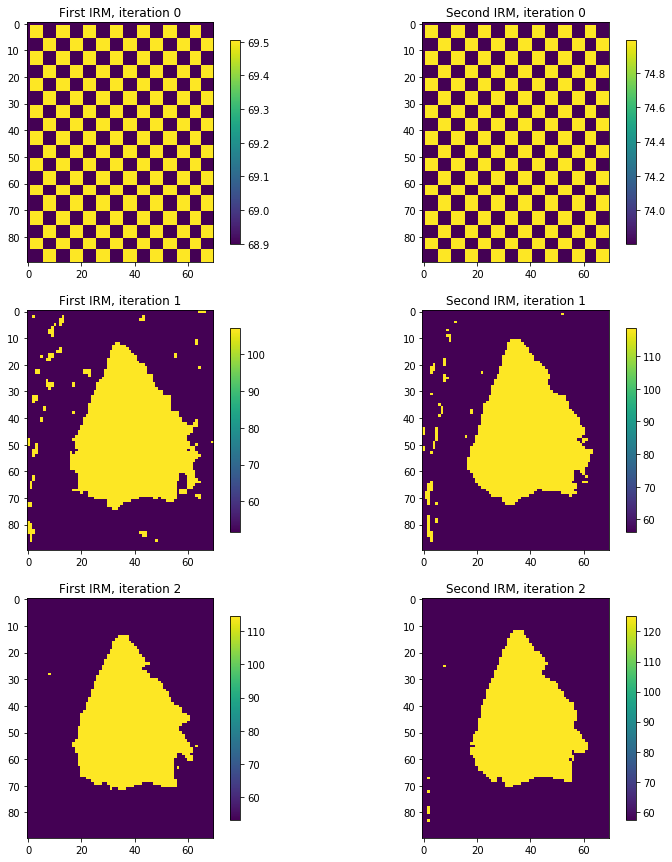

In [7]:
nb = 3
plt.figure(figsize=(13, 5 * nb))

for i in range(nb):
    plt.subplot(nb, 2, 2 * i + 1)
    plt.imshow(images1[i])
    plt.title('First IRM, iteration {}'.format(i))
    plt.colorbar(shrink=0.85)

    plt.subplot(nb, 2, 2 * i + 2)
    plt.imshow(images2[i])
    plt.title('Second IRM, iteration {}'.format(i))
    plt.colorbar(shrink=0.85)

## Extraction of the tumor from the snippets :

In [8]:
threshold1 = np.unique(images1[-1]).mean()
threshold2 = np.unique(images2[-1]).mean()

# Making Empty new images
Tumor1 = np.zeros(IRMcoupe17_t1.shape)
Tumor2 = np.zeros(IRMcoupe17_t2.shape)


for i in range(xMin, xMax):
    for j in range(yMin, yMax):
        if images1[-1][i-xMin,j-yMin] > threshold1:
            Tumor1[i,j] = 1
        if images2[-1][i-xMin,j-yMin] > threshold2:
            Tumor2[i,j] = 1

## Computing the growth factor and finding the contour of the Tumor :

In [9]:
growthFactor = 100*(np.sum(Tumor2) - np.sum(Tumor1))/np.sum(Tumor1)

IRMcoupe17_t1_Diagnose = IRMcoupe17_t1.copy()
IRMcoupe17_t2_Diagnose = IRMcoupe17_t2.copy()
# Finding the tumor contour
for i, j in measure.find_contours(Tumor1, level=0)[0]:
    IRMcoupe17_t1_Diagnose[int(i)][int(j)] = 200

for i, j in measure.find_contours(Tumor2, level=0)[0]:
    IRMcoupe17_t2_Diagnose[int(i)][int(j)] = 200

## Visualization

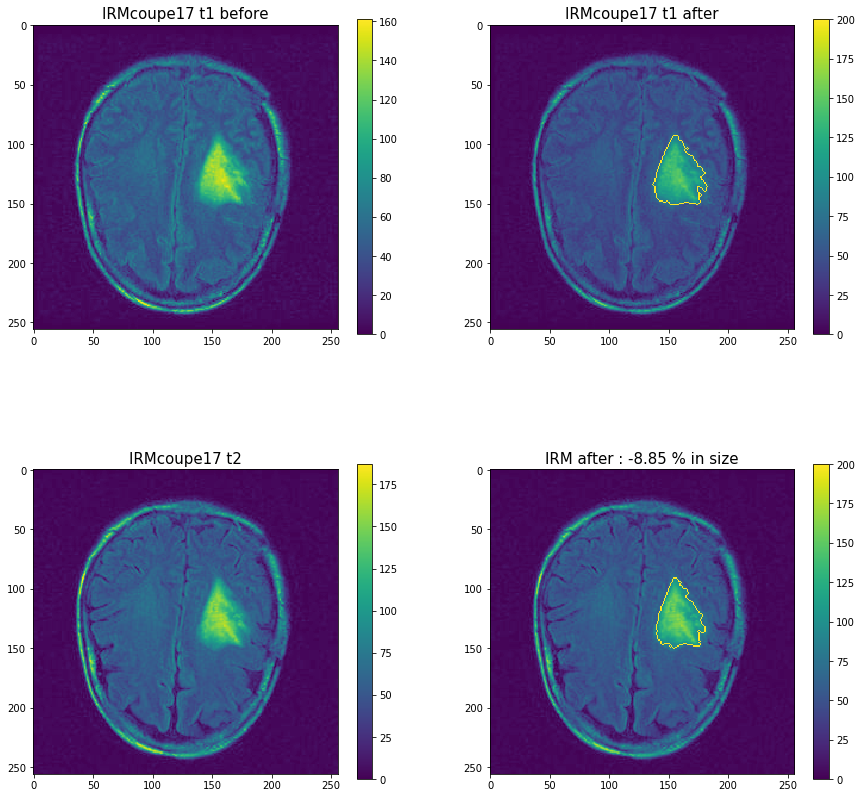

In [10]:
plt.figure(figsize=(15,15))

plt.subplot(2, 2, 1)
plt.imshow(IRMcoupe17_t1)
plt.title('IRMcoupe17 t1 before', fontsize=15)
plt.colorbar(shrink=0.85)

plt.subplot(2, 2, 2)
plt.imshow(IRMcoupe17_t1_Diagnose)
plt.title('IRMcoupe17 t1 after', fontsize=15)
plt.colorbar(shrink=0.85)


plt.subplot(2, 2, 3)
plt.imshow(IRMcoupe17_t2)
plt.title('IRMcoupe17 t2', fontsize=15)
plt.colorbar(shrink=0.85)

plt.subplot(2, 2, 4)
plt.imshow(IRMcoupe17_t2_Diagnose)
plt.title('IRM after : {0:.2f} % in size'.format(growthFactor), fontsize=15)
plt.colorbar(shrink=0.85)

plt.show()